# Intro
This is a jupyter notebook containing  code relevant to finding distant pairs using only the jaccard index  

This code is part of the BiG-SCAPE 2.0 thesis project  

Start by importing these modules

In [2]:
import plots.hist

import truth.truth as truth

import predictions
import predictions.tests

import validation

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

The following code instantiates any relevant paths to data or output. Make sure to change these for your purposes.
Not all the paths may be relevant, e.g. if you are using the bigscape_distances.tsv that is included in this repository.

In [3]:

# location of the core and bio pfam information tab separated files.
# these are included in this repository, but if you want to get them from BiG-SLICE directly point them to their respective locations
CORE_PFAM_TSV = "corepfam.tsv"
BIO_PFAM_TSV = "biopfam.tsv"
    # location of the full bigscape distances tab separated file.
# this file is created if you are loading new values from a run using the path after this one
FULL_TSV = "bigscape_distances.tsv"
# Base folder of Cluster files generated by BiG-SCAPE for a run. e.g:
BIGSCAPE_CLUSTER_FILES = "D:/Temp/2022-03-22_09-18-06_hybrids_global"


The following code loads data from a BiG-SCAPE run. Point the RUN_PATH to a BiG-SCAPE result folder and it will collect all BGC pair distances
It will then save these distances to the bigscape_distances.tsv file indicated by the FULL_TSV path above

In [4]:
print("Loading truth")
# load truth values
TRUTH_DISTANCES = truth.from_file(FULL_TSV)
print("Loading jaccard indexes")
JACCARD_INDEXES = truth.get_jaccard_from_results(BIGSCAPE_CLUSTER_FILES, "1.00")
print("Getting truth pairs")
TRUTH_PAIRS = validation.pairs_from_distances(TRUTH_DISTANCES)


Loading truth
Loading jaccard indexes
Getting truth pairs


Plot jaccard index vs BiG-SCAPE distances
Theoretically this should have a negative correlation

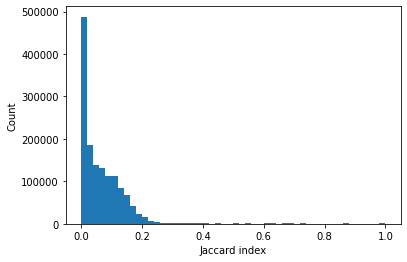

1440847 pairs in jaccard indexes


In [5]:
# show hist of true distances
plots.hist.from_distances(JACCARD_INDEXES, max=len(TRUTH_DISTANCES), bins=50, xlab="Jaccard index", ylab="Count")
print(len(JACCARD_INDEXES), "pairs in jaccard indexes")

Generating distance/index dictionary


Text(0, 0.5, 'BiG-SCAPE distance')

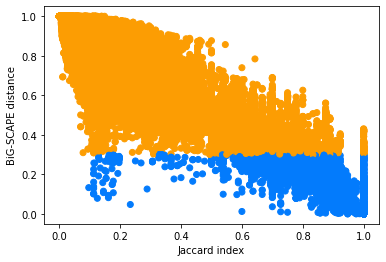

In [6]:
print("Generating distance/index dictionary")
BIGSCAPE_JACCARD_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    BIGSCAPE_JACCARD_DICT[pair_key] = [dist]

for bgc1, bgc2, idx in JACCARD_INDEXES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # ignore duplicates
    if (len(BIGSCAPE_JACCARD_DICT[pair_key]) == 1):
        BIGSCAPE_JACCARD_DICT[pair_key].append(idx)

x = []
y = []
l = []
for i, item in BIGSCAPE_JACCARD_DICT.items():
    dist, idx = item
    x.append(idx)
    y.append(dist)
    if dist < 0.3:
        l.append("#037bfc")
    else:
        l.append("#fc9d03")

plt.scatter(x, y, c=l)
plt.xlabel("Jaccard index")
plt.ylabel("BiG-SCAPE distance")

Plot jaccard distances

Vast majority of jaccard distances are 0  
Let's see if we can do some lower bound exclusion

In [7]:
results_lower = predictions.tests.distance.run_lower(
    JACCARD_INDEXES,
    TRUTH_PAIRS,
    lower_range=20,
    lower_cutoff_step=0.02,
    lower_cutoff_start=0.02
)

Predictions from distances (lower only):
cut_low,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.02,486045,0,861602,0.0,NA,0.0,0.0,0.0,NA,0,486045,0,0
0.04,668571,0,679076,0.0,NA,0.0,0.0,0.0,NA,0,668571,0,0
0.06,802111,0,545536,0.0,NA,0.0,0.0,0.0,NA,0,802111,0,0
0.08,926876,0,420771,0.0,NA,0.0,0.0,0.0,NA,0,926876,0,0
0.1,1028320,0,319327,0.0,1.0,0.0,0.0,0.0,NA,1,1028319,0,0
0.12,1126746,0,220901,0.0,1.0,0.0,0.0,0.0,NA,12,1126734,0,0
0.14,1195957,0,151690,0.0,1.0,0.0,0.0,0.0,NA,18,1195939,0,0
0.16,1248157,0,99490,0.0,1.0,0.0,0.0,0.0,NA,26,1248131,0,0
0.18,1279890,0,67757,0.0,1.0,0.0,0.0,0.0,NA,55,1279835,0,0
0.2,1297959,0,49688,0.0,1.0,0.0,0.0,0.0,NA,70,1297889,0,0
0.22,1309668,0,37979,0.0,1.0,0.0,0.0,0.0,NA,70,1309598,0,0
0.24,1315334,0,32313,0.0,1.0,0.0,0.0,0.0,NA,71,1315263,0,0
0.26,1318529,0,29118,0.0,1.0,0.0,0.0,0.0,NA,72,1318457,0,0
0.28,1320831,0,26816,0.0,1.0,0.0,0.0,0.0,NA,73,1320758,0,0
0.3,1322099,0,25548,0.0,1.0,0.0,0.0,0.0,NA,74,1322025,0,0
0.32,1323787,0,23860,

(0.0, 100.0)

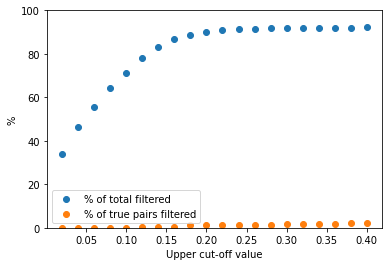

In [8]:
x_upper = []
y1_upper = []
y2_upper = []
# get results for upper cutoffs into arrays
for result_lower in results_lower:
    cutoff, tp, fp, tn, fn = result_lower
    # get % of total pairs filtered out
    perc_filtered = (tp+fp)/len(TRUTH_DISTANCES) * 100
    # get % of incorrectly filtered pairs
    perc_incorrect = tp/len(TRUTH_PAIRS[0]) * 100
    x_upper.append(cutoff)
    
    y1_upper.append(perc_filtered)
    y2_upper.append(perc_incorrect)

# upper cutoff stats
upper_filter_line = plt.scatter(x_upper, y1_upper)
upper_incorrect_line = plt.scatter(x_upper, y2_upper)
plt.legend([upper_filter_line, upper_incorrect_line], ["% of total filtered", "% of true pairs filtered"])
plt.xlabel("Upper cut-off value")
plt.ylabel("%")
plt.ylim(0, 100)

The above table is a bit confusing since we actually want to have the pairs above the cutoff be unclassified, and anything below it to be negative.

Thus the tp are incorrect classifications and the fp are correctly unclassified  

There are some good gains from excluding low jaccard distance pairs here. Let's take a look at the upper range as well

In [7]:
results_upper = predictions.tests.distance.run_upper(
    JACCARD_INDEXES,
    TRUTH_PAIRS,
    upper_range=20,
    upper_cutoff_step=0.02,
    upper_cutoff_start=0.2
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.2,0,49688,1297959,NA,0.0,1.0,0.904,NA,0.904,0,0,44950,4773
0.22,0,37979,1309668,NA,0.0,1.0,0.874,NA,0.874,0,0,33241,4773
0.24,0,32313,1315334,NA,0.0,1.0,0.852,NA,0.852,0,0,27576,4772
0.26,0,29118,1318529,NA,0.0,1.0,0.836,NA,0.836,0,0,24382,4771
0.28,0,26816,1320831,NA,0.0,1.0,0.822,NA,0.822,0,0,22081,4770
0.3,0,25548,1322099,NA,0.0,1.0,0.814,NA,0.814,0,0,20814,4769
0.32,0,23860,1323787,NA,0.0,1.0,0.801,NA,0.801,0,0,19130,4763
0.34,0,22372,1325275,NA,0.0,1.0,0.788,NA,0.788,0,0,17651,4754
0.36,0,21381,1326266,NA,0.0,1.0,0.778,NA,0.778,0,0,16664,4750
0.38,0,20390,1327257,NA,0.0,1.0,0.768,NA,0.768,0,0,15686,4737
0.4,0,19430,1328217,NA,0.0,1.0,0.757,NA,0.757,0,0,14731,4732
0.42,0,18199,1329448,NA,0.0,1.0,0.741,NA,0.741,0,0,13504,4728
0.44,0,17687,1329960,NA,0.0,1.0,0.733,NA,0.733,0,0,12997,4723
0.46,0,16704,1330943,NA,0.0,1.0,0.718,NA,0.718,0,0,12016,4720
0.48,0,16110,1331537,NA,0.0,

[(0.2, 0, 0, 44950, 4773),
 (0.22, 0, 0, 33241, 4773),
 (0.24, 0, 0, 27576, 4772),
 (0.26, 0, 0, 24382, 4771),
 (0.28, 0, 0, 22081, 4770),
 (0.3, 0, 0, 20814, 4769),
 (0.32, 0, 0, 19130, 4763),
 (0.34, 0, 0, 17651, 4754),
 (0.36, 0, 0, 16664, 4750),
 (0.38, 0, 0, 15686, 4737),
 (0.4, 0, 0, 14731, 4732),
 (0.42, 0, 0, 13504, 4728),
 (0.44, 0, 0, 12997, 4723),
 (0.46, 0, 0, 12016, 4720),
 (0.48, 0, 0, 11424, 4718),
 (0.5, 0, 0, 11325, 4717),
 (0.52, 0, 0, 9925, 4696),
 (0.54, 0, 0, 9295, 4664),
 (0.56, 0, 0, 8221, 4657),
 (0.58, 0, 0, 7802, 4651)]

Not really much that can be found here. This makes sense since a high jaccard index would mean that there are more common domains, which means that the AI and DSS should matter more